In [4]:
import math
import operator
import os
import tempfile
from functools import reduce

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy import ndimage

In [5]:
def set_image_dpi(path_file):
    im = Image.open(path_file)
    factor = min(1, 1024.0 / im.width)
    size = (int(factor * im.width), int(factor * im.height))
    im_resized = im.resize(size, Image.LANCZOS)
    with tempfile.NamedTemporaryFile(delete=False, suffix='.png') as temp_file:
        temp_filename = temp_file.name
        im_resized.save(temp_filename, dpi=(300, 300))
    return temp_filename

def grabcut_segmentation(img):    
    # Create a mask initialized with zeros
    mask = np.zeros(img.shape[:2], np.uint8)
    
    # Create foreground and background models
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64)
    
    # Define a rectangle around the object to help GrabCut algorithm
    rect = (50, 50, img.shape[1]-50, img.shape[0]-50)
    
    # Apply GrabCut algorithm
    cv2.grabCut(img, mask, rect, bgd_model, fgd_model, 30, cv2.GC_INIT_WITH_RECT)
    
    # Modify the mask to create binary mask for the foreground
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    
    # Multiply the image with the binary mask to get the segmented image
    segmented_img = img * mask2[:, :, np.newaxis]
    
    return segmented_img

def sort_points_clockwise(points):
    def get_angle(point, center):
        x, y = point[0] - center[0], point[1] - center[1]
        return math.atan2(y, x)

    # Find the center of the points
    center = [sum(p[0] for p in points) / len(points), sum(p[1] for p in points) / len(points)]

    # Sort points based on the angle with respect to the center
    sorted_points = sorted(points, key=lambda p: get_angle(p, center))

    return sorted_points

def calculate_corners(image_original, gray, canny):
    # Blank canvas.
    con = image_original.copy()
    # Finding contours for the detected edges.
    contours, _ = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # Keeping only the largest detected contour.
    page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

    # Loop over the contours.
    for c in page:
        # Approximate the contour.
        epsilon = 0.02 * cv2.arcLength(c, True)
        corners = cv2.approxPolyDP(c, epsilon, True)
        # If our approximated contour has four points
        if len(corners) >= 4:
            break
        cv2.drawContours(con, c, -1, (0, 255, 255), 3)
        cv2.drawContours(con, corners, -1, (0, 255, 0), 10)

    # Sorting the corners and converting them to desired shape.
    # corners = sorted(np.concatenate(corners).tolist())
    corners = sort_points_clockwise(np.concatenate(corners).tolist())

    # Displaying the corners.
    for index, c in enumerate(corners):
        character = chr(65 + index)
        cv2.putText(con, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1, cv2.LINE_AA)
    return con, corners

def transform_perspective(image_original, corners):
    (tl, tr, br, bl) = corners
    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]

    # Getting the homography.
    M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
    # Perspective transform using homography.
    final = cv2.warpPerspective(image_original, M, (destination_corners[2][0], destination_corners[2][1]), flags=cv2.INTER_LINEAR)

    return final

test
UTOP_Receipt Recognitions


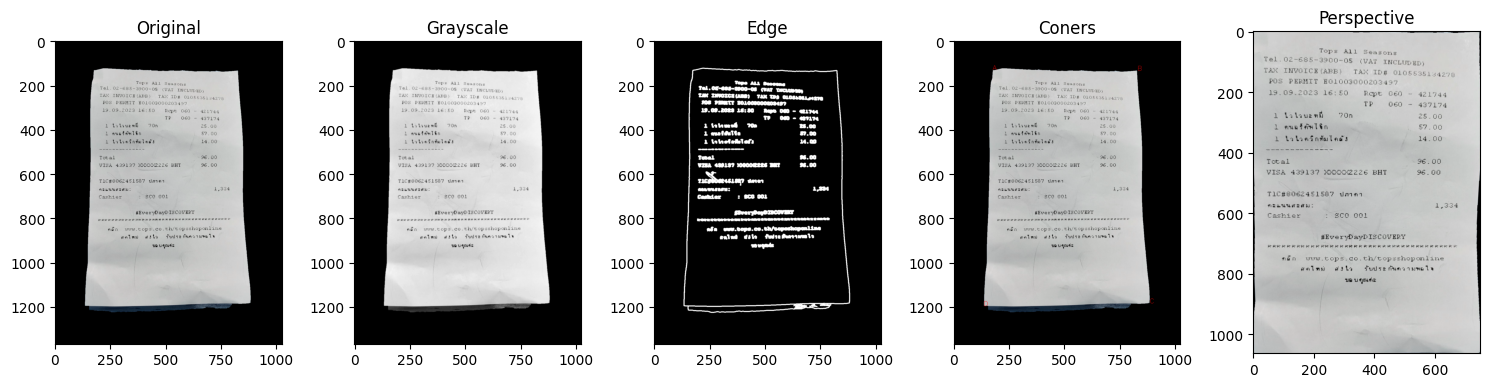

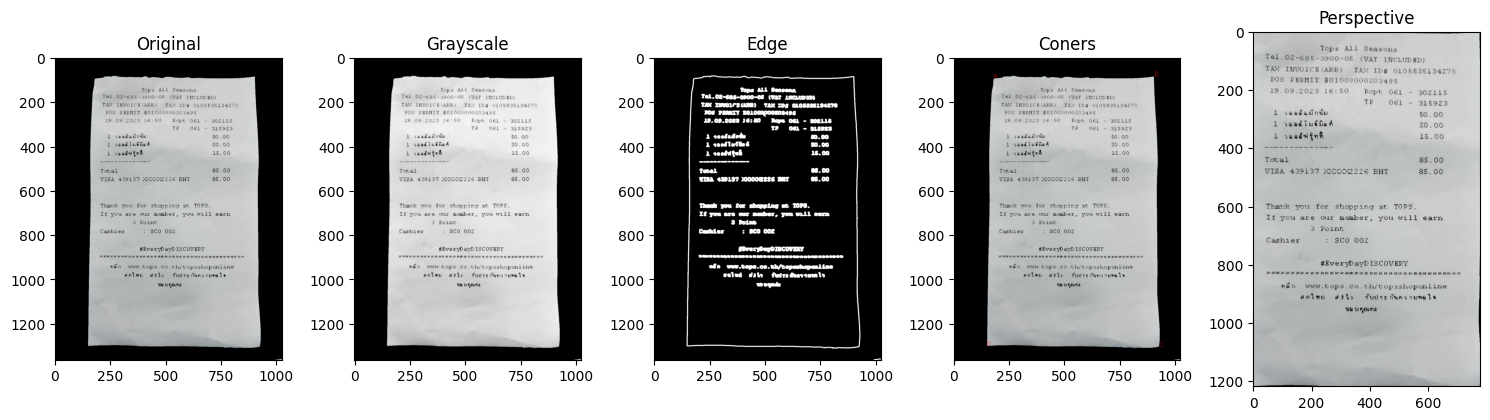

ValueError: too many values to unpack (expected 4)

In [3]:
def process_image(path_image):
    path_image = set_image_dpi(path_image)
    image_original = grabcut_segmentation(path_image)

         
    # Repeated Closing operation to remove text from the document.
    # kernel = np.ones((5,5),np.uint8)
    # image = cv2.morphologyEx(image_original, cv2.MORPH_CLOSE, kernel, iterations= 3)

    gray = cv2.cvtColor(image_original, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)
    # Edge Detection.
    canny = cv2.Canny(gray, 0, 200)
    canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

    con, corners = calculate_corners(image_original, gray, canny)
    rotated = transform_perspective(image_original, gray, canny, corners)
    return image_original, gray, canny, con, rotated

base_directory = 'Recipe'
for folder_path in os.listdir(base_directory):
    print(folder_path)
    if folder_path != 'test':
        folder_full_path = os.path.join(base_directory, folder_path)
        for png in os.listdir(folder_full_path):
          
            image_path = os.path.join(folder_full_path, png)
            image, gray, canny, con, rotated = process_image(image_path)

            # Plotting
            titles = ['Original', 'Grayscale', 'Edge', 'Coners', 'Perspective']
            images = [image, gray, canny, con, rotated]

            plt.figure(figsize=(15, 5))
            for i in range(len(images)):
                plt.subplot(1, 5, i + 1)
                plt.imshow(images[i], 'gray')
                plt.title(titles[i])
                # plt.axis('off')

            plt.tight_layout()
            plt.show()


Segmented
test
UTOP_Receipt Recognitions


C:\Users\User\AppData\Local\Temp\ipykernel_15532\467695625.py:18: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


4 [[ 135 1192]
 [ 152  121]
 [ 898  133]
 [ 881 1204]]


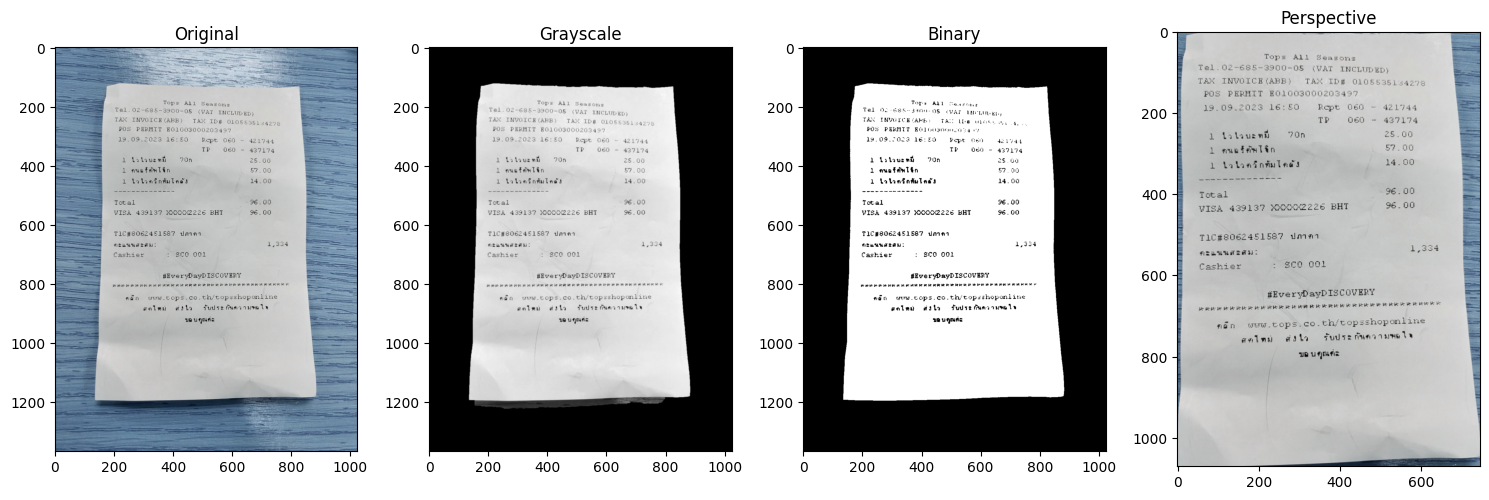

4 [[ 149 1306]
 [ 153   85]
 [ 930   88]
 [ 926 1309]]


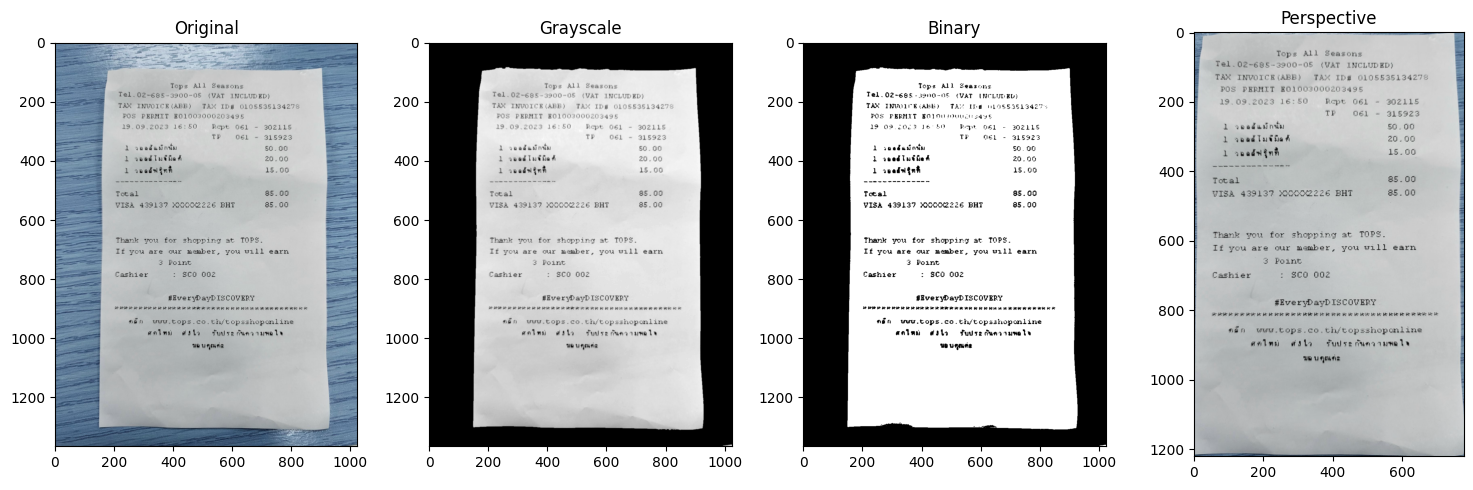

4 [[ 161   93]
 [ 835   93]
 [ 835 1214]
 [ 161 1214]]


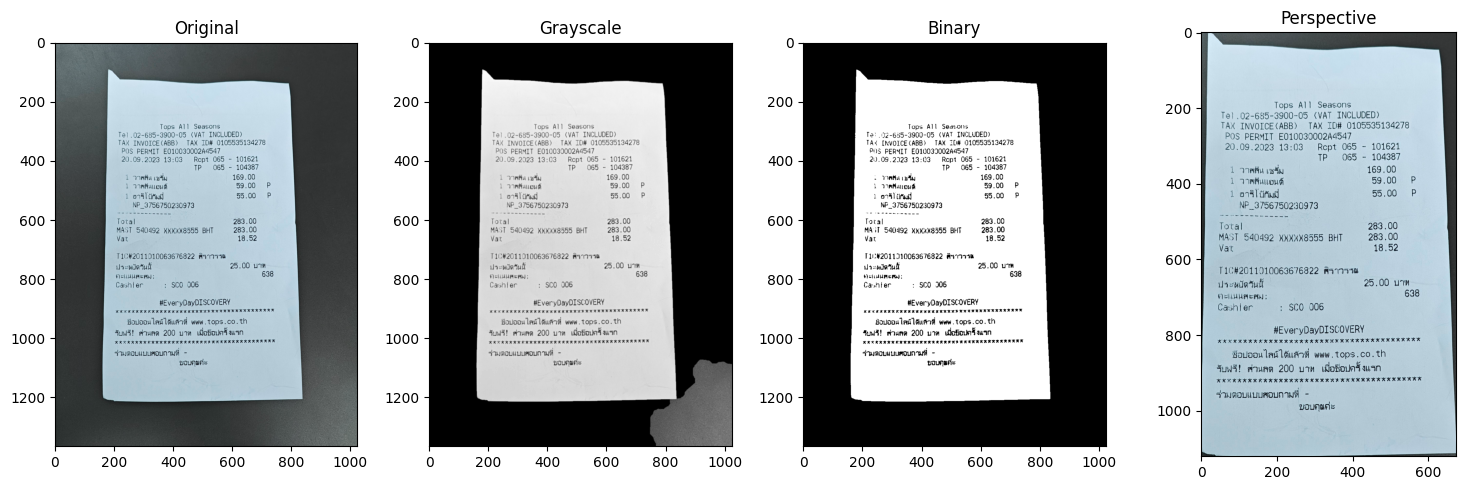

4 [[ 212  155]
 [ 842  148]
 [ 852 1193]
 [ 222 1199]]


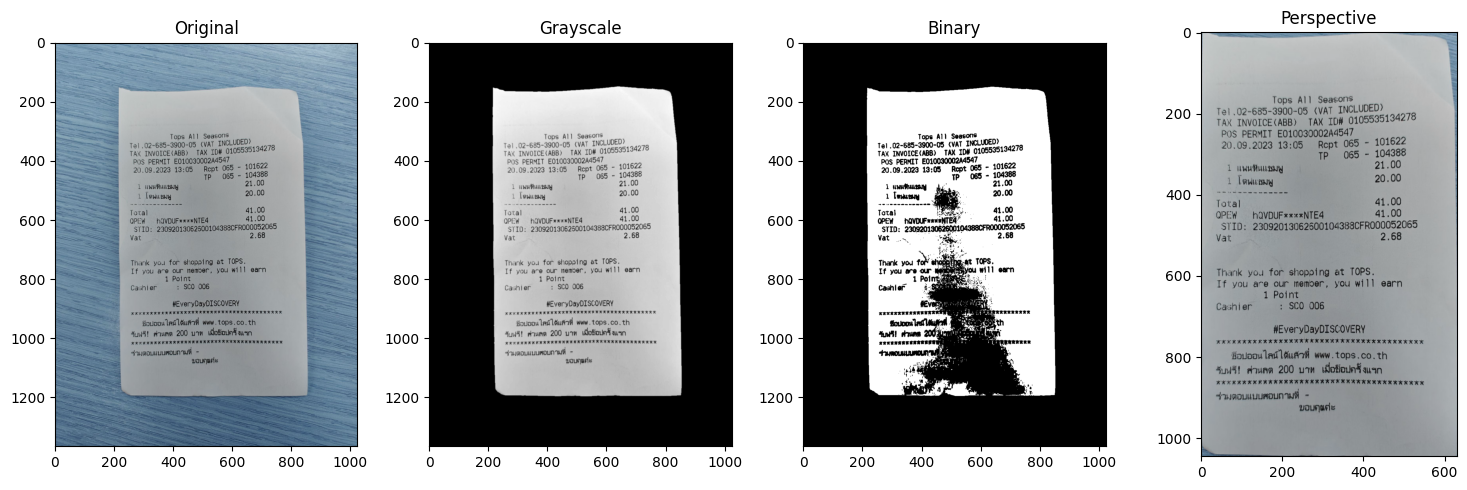

4 [[ 265   55]
 [ 755   50]
 [ 766 1167]
 [ 276 1172]]


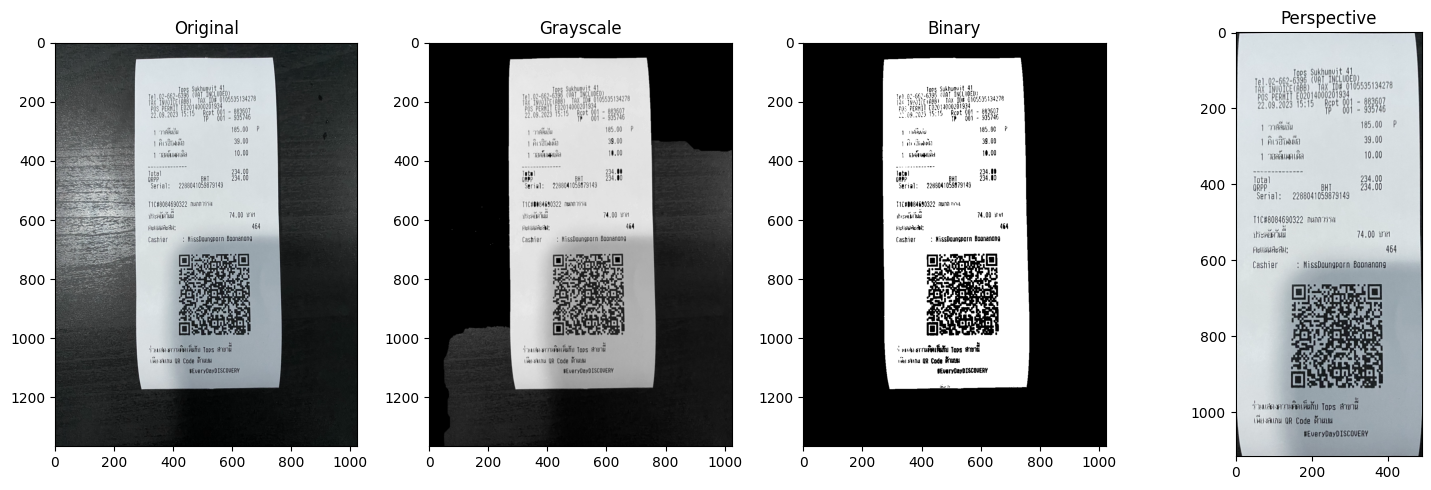

UTOP_Receipt Recognitions_Batch2
4 [[ 140 1363]
 [ 148   45]
 [ 908   50]
 [ 900 1368]]


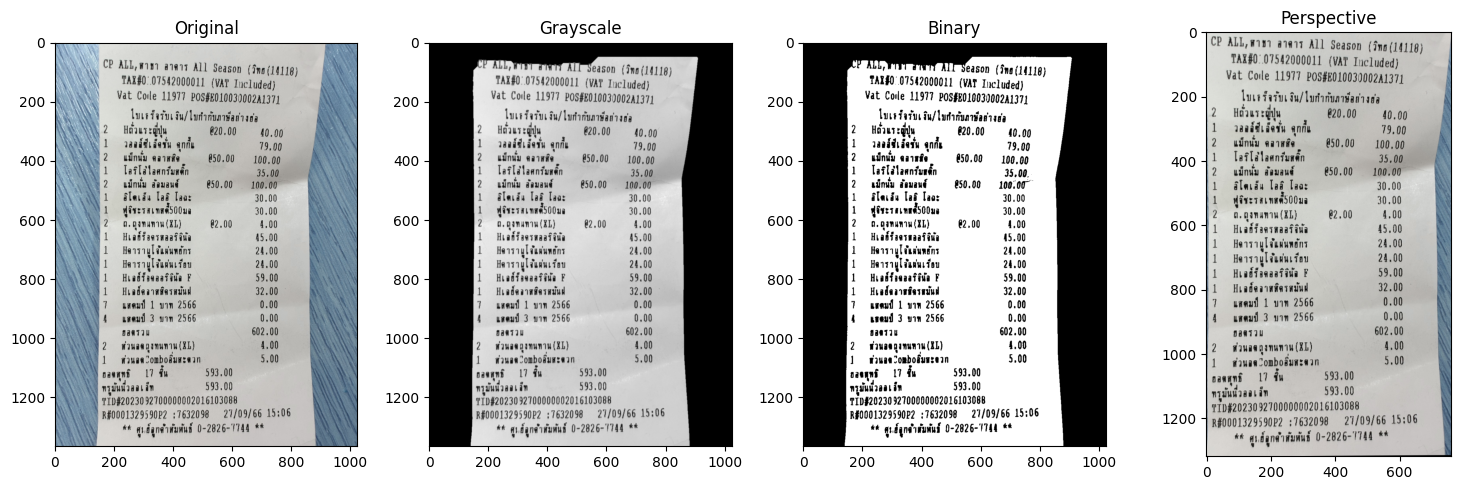

4 [[197  53]
 [197  53]
 [197  53]
 [197  53]]


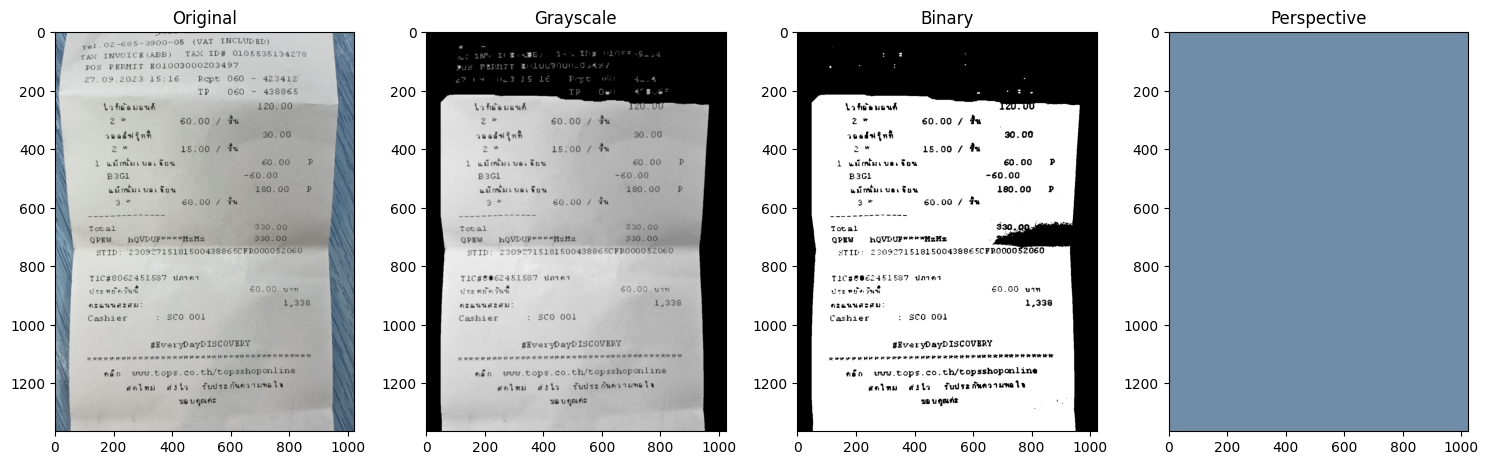

4 [[  70   51]
 [1023   51]
 [1023 1364]
 [  70 1364]]


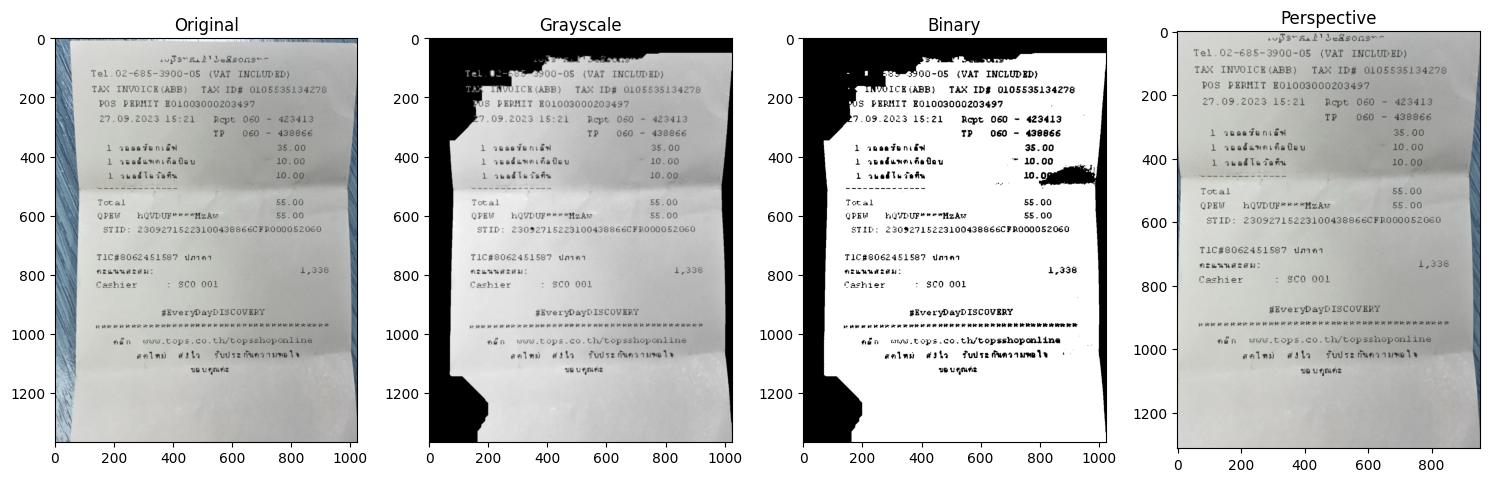

4 [[ 206  535]
 [ 854  533]
 [ 855 1128]
 [ 208 1130]]


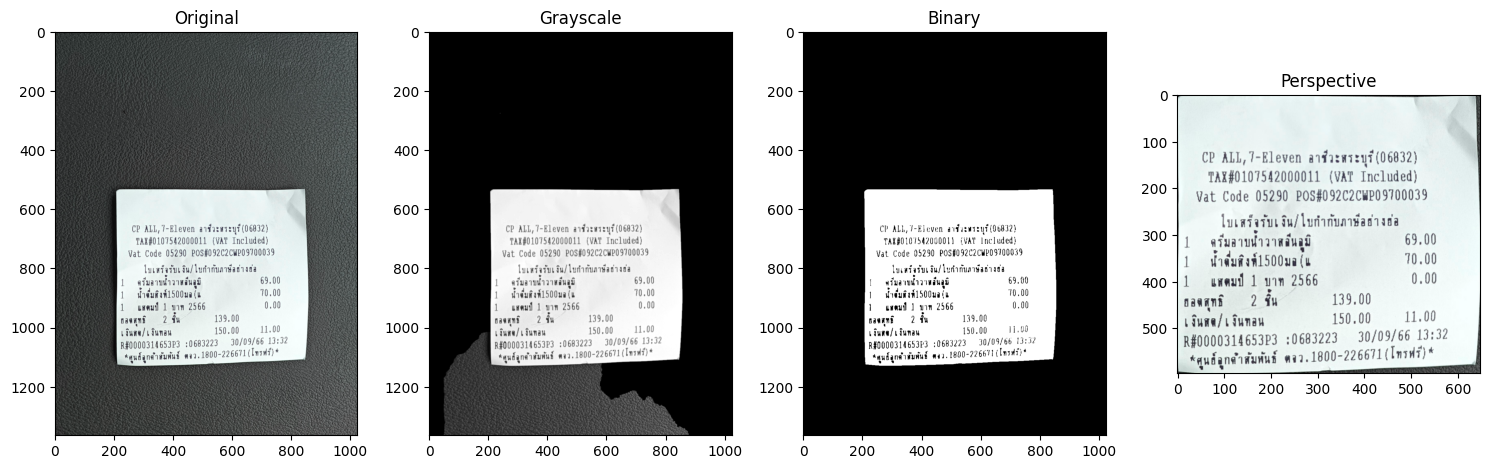

4 [[ 218  111]
 [ 800  111]
 [ 800 1364]
 [ 218 1364]]


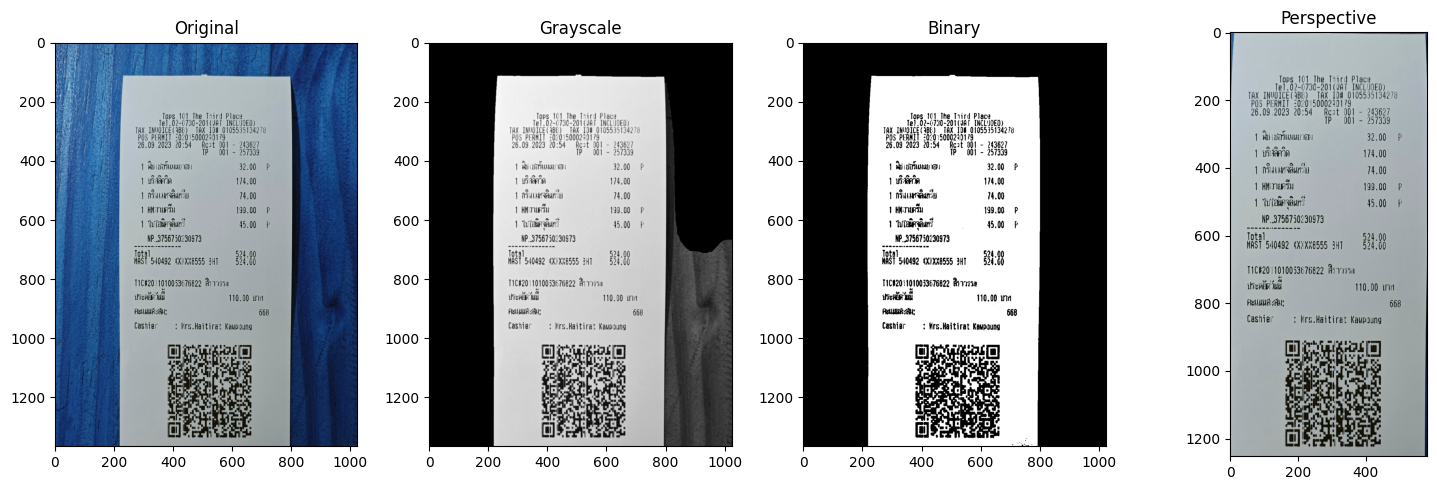

4 [[ 218  111]
 [ 800  111]
 [ 800 1364]
 [ 218 1364]]


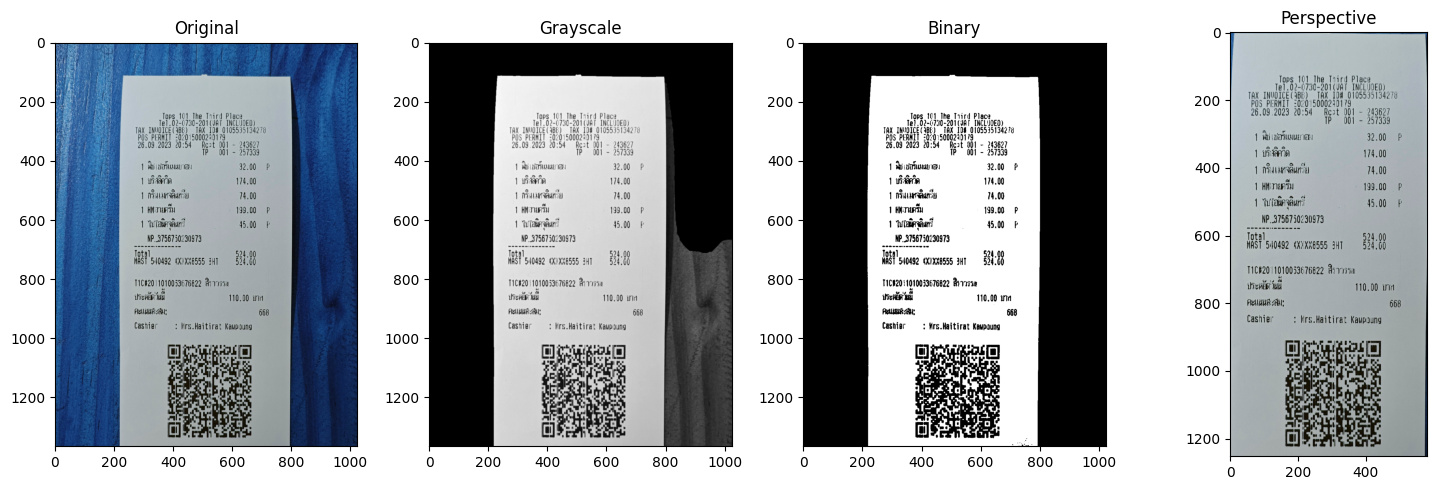

4 [[ 242  174]
 [ 728  145]
 [ 796 1292]
 [ 310 1321]]


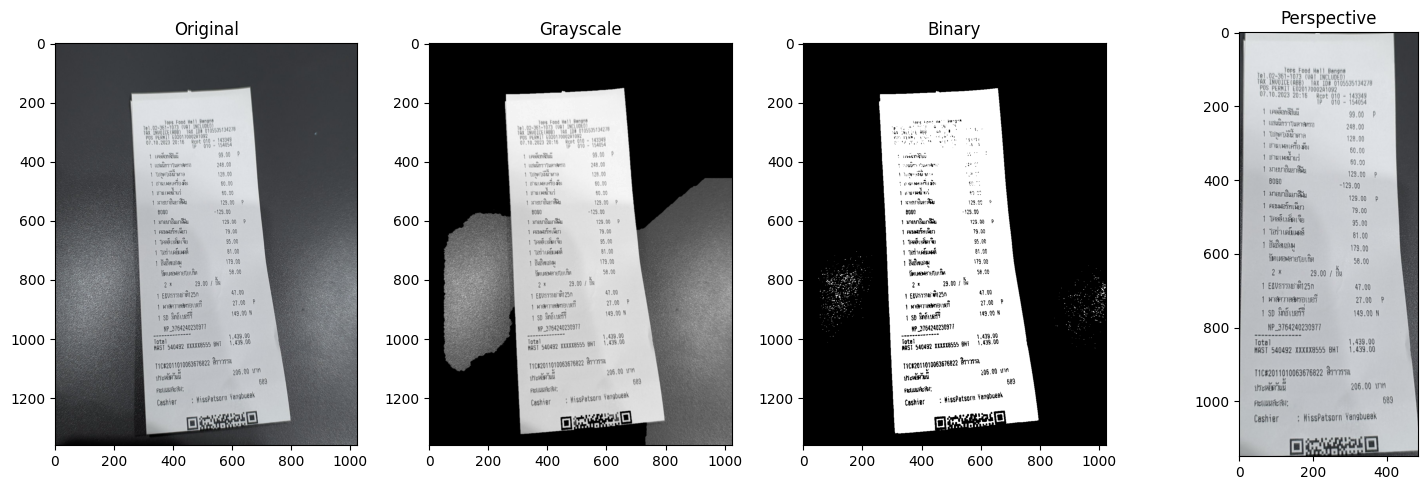

In [11]:
def process_image(path_image):
    path_image = set_image_dpi(path_image)
    image_original = cv2.imread(path_image, 1)
    image_segmented = grabcut_segmentation(image_original)

    gray = cv2.cvtColor(image_segmented, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    _, thresh_gray = cv2.threshold(gray,
                        150, 255, cv2.THRESH_BINARY)
    
    contours, _ = cv2.findContours(thresh_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    for c in contours:
        rect = cv2.minAreaRect(c)
        box = cv2.boxPoints(rect)
        # convert all coordinates floating point values to int
        box = np.int0(box)
        # draw a green 'nghien' rectangle
        # cv2.drawContours(image_original, [box], 0, (0, 255, 0),1)
        
    print(len(box), box)
    box = sort_points_clockwise(box)
    rotated = transform_perspective(image_original, box)
    return image_original, gray, thresh_gray, _, rotated

base_directory = 'Recipe'
for folder_path in os.listdir(base_directory):
    print(folder_path)
    if folder_path != 'test':
        folder_full_path = os.path.join(base_directory, folder_path)
        for png in os.listdir(folder_full_path):
          
            image_path = os.path.join(folder_full_path, png)
            image_original, gray, thresh_gray, _, rotated = process_image(image_path)

            # Plotting
            titles = ['Original', 'Grayscale', 'Binary', 'Perspective']
            images = [image_original, gray, thresh_gray, rotated]

            cv2.imwrite(f'Recipe/Segmented/{os.path.basename(image_path)}', rotated)
            plt.figure(figsize=(15, 5))
            for i in range(len(images)):
                plt.subplot(1, 4, i + 1)
                plt.imshow(images[i], 'gray')
                plt.title(titles[i])
                # plt.axis('off')

            plt.tight_layout()
            plt.show()
